# *Enunciado*
1.      Desarrolle un modelo de identificación de objetos utilizando el **dataset CIFAR10**, para imágenes del tamaño de **64x64 pixeles** y con **3 canales de colores**, utilizando un modelo convolucional que contemple **4 capa convolucionales** con sus **respectivas capas de pooling**, los parámetros para **las capas convolucionales** serán: **kernel = 5**, **padding = 0**, y el **strike = 2**, para **el pooling**: **kernel = 2**, **strike = 1**, en base a estos datos identificar con cuantas convoluciones se logra el mejor entrenamiento.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_path = '/content/drive/MyDrive/Datasets/CIFAR/cifar.zip'
with ZipFile(file_path, 'r') as zip:
  zip.extractall('.')

In [ ]:
import os 
PATH = '/content/cifar10-64/train'

classes = os.listdir(PATH)
classes = ['0 avion', '1 auto', '2 pajaro', '3 gato', '4 antilope', '5 perro', '6 rana', '7 caballo', '8 bote', '9 camion']

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "png"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: 0 avion. Imágenes: 5000
Categoría: 1 auto. Imágenes: 5000
Categoría: 2 pajaro. Imágenes: 5000
Categoría: 3 gato. Imágenes: 5000
Categoría: 4 antilope. Imágenes: 5000
Categoría: 5 perro. Imágenes: 5000
Categoría: 6 rana. Imágenes: 5000
Categoría: 7 caballo. Imágenes: 5000
Categoría: 8 bote. Imágenes: 5000
Categoría: 9 camion. Imágenes: 5000


In [ ]:
len(imgs)

50000

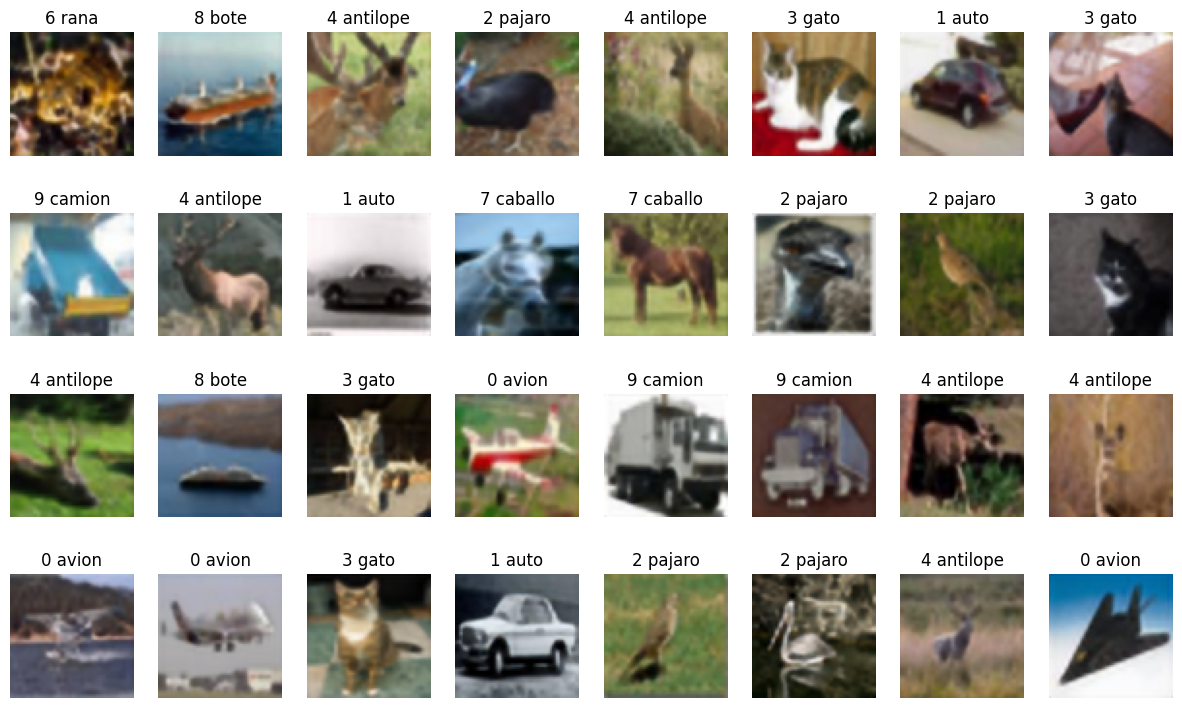

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4,8, figsize=(15,9))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.25, stratify=labels)

len(train_imgs), len(test_imgs)

(37500, 12500)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = io.imread(self.X[ix])
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
import albumentations as A 

trans = A.Compose([
    A.Resize(128, 128) #<---------
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(37500, 12500)

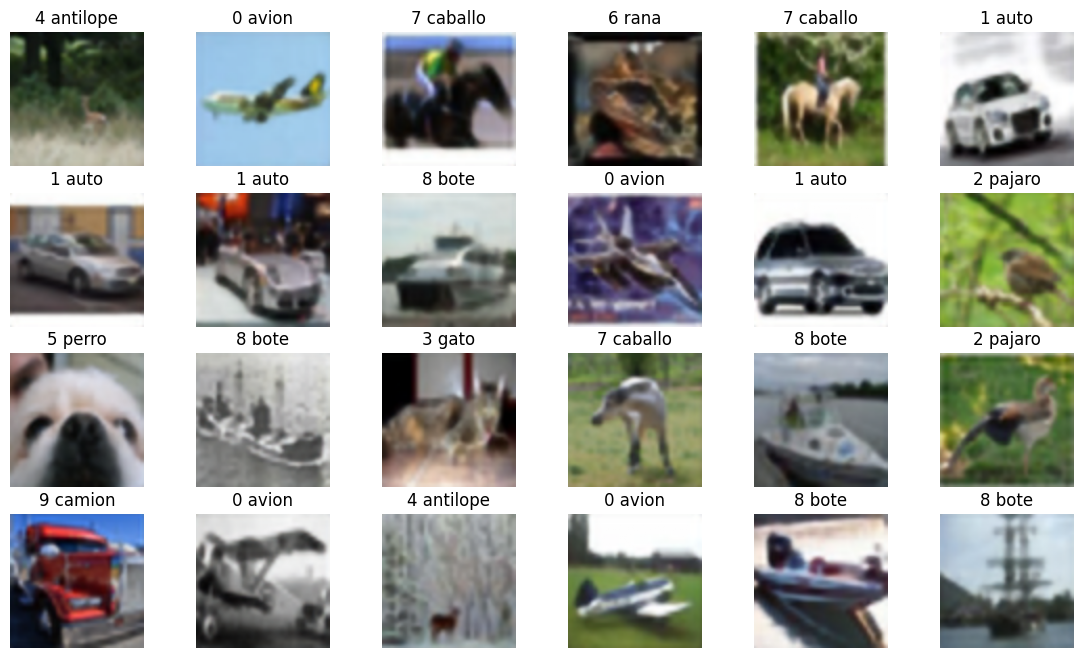

In [ ]:
fig, axs = plt.subplots(4,6, figsize=(14,8))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 128, 128])

In [ ]:
import torch.nn as nn

class ModelCustom(nn.Module):
    def __init__(self, n_outputs):
        super(ModelCustom, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=0)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6400, 512)
        self.relu5 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
model_custom = ModelCustom(n_outputs=10)
outputs = model_custom(torch.randn(64, 3, 128, 128))
print(outputs.shape)

torch.Size([64, 10])


In [ ]:
import os
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=10, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        checkpoint_path = f"checkpoint_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_path)

In [ ]:
model_c = ModelCustom(10)
fit(model_c, dataloader, epochs=20)

val_loss 1.25194 val_acc 0.54658: 100%|██████████| 49/49 [00:17<00:00,  2.83it/s]


Epoch 1/20 loss 1.49595 val_loss 1.25194 acc 0.45595 val_acc 0.54658


val_loss 1.18437 val_acc 0.58284: 100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


Epoch 2/20 loss 1.12161 val_loss 1.18437 acc 0.60351 val_acc 0.58284


val_loss 1.11481 val_acc 0.59651: 100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


Epoch 3/20 loss 0.94961 val_loss 1.11481 acc 0.66687 val_acc 0.59651


val_loss 1.02042 val_acc 0.64139: 100%|██████████| 49/49 [00:16<00:00,  2.89it/s]


Epoch 4/20 loss 0.83961 val_loss 1.02042 acc 0.70474 val_acc 0.64139


val_loss 0.83265 val_acc 0.70803: 100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


Epoch 5/20 loss 0.74787 val_loss 0.83265 acc 0.73820 val_acc 0.70803


val_loss 0.84452 val_acc 0.71651: 100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


Epoch 6/20 loss 0.67337 val_loss 0.84452 acc 0.76694 val_acc 0.71651


val_loss 0.79481 val_acc 0.72346: 100%|██████████| 49/49 [00:16<00:00,  2.90it/s]


Epoch 7/20 loss 0.60972 val_loss 0.79481 acc 0.78889 val_acc 0.72346


val_loss 0.83062 val_acc 0.71972: 100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


Epoch 8/20 loss 0.54950 val_loss 0.83062 acc 0.80872 val_acc 0.71972


val_loss 0.76561 val_acc 0.73991: 100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


Epoch 9/20 loss 0.48957 val_loss 0.76561 acc 0.82979 val_acc 0.73991


val_loss 0.72068 val_acc 0.75719: 100%|██████████| 49/49 [00:17<00:00,  2.80it/s]


Epoch 10/20 loss 0.44243 val_loss 0.72068 acc 0.84587 val_acc 0.75719


val_loss 0.73750 val_acc 0.75306: 100%|██████████| 49/49 [00:16<00:00,  2.92it/s]


Epoch 11/20 loss 0.39209 val_loss 0.73750 acc 0.86492 val_acc 0.75306


val_loss 0.71438 val_acc 0.76603: 100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


Epoch 12/20 loss 0.33702 val_loss 0.71438 acc 0.88512 val_acc 0.76603


val_loss 0.82637 val_acc 0.74590: 100%|██████████| 49/49 [00:16<00:00,  2.91it/s]


Epoch 13/20 loss 0.28842 val_loss 0.82637 acc 0.90120 val_acc 0.74590


val_loss 0.76714 val_acc 0.76431: 100%|██████████| 49/49 [00:17<00:00,  2.83it/s]


Epoch 14/20 loss 0.25503 val_loss 0.76714 acc 0.91285 val_acc 0.76431


val_loss 1.20282 val_acc 0.67136: 100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 15/20 loss 0.20457 val_loss 1.20282 acc 0.93203 val_acc 0.67136


val_loss 0.86378 val_acc 0.74659: 100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 16/20 loss 0.17876 val_loss 0.86378 acc 0.94064 val_acc 0.74659


val_loss 0.87459 val_acc 0.74563: 100%|██████████| 49/49 [00:16<00:00,  2.96it/s]


Epoch 17/20 loss 0.14878 val_loss 0.87459 acc 0.95021 val_acc 0.74563


val_loss 0.80029 val_acc 0.77082: 100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Epoch 18/20 loss 0.12084 val_loss 0.80029 acc 0.96211 val_acc 0.77082


val_loss 0.83543 val_acc 0.77108: 100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 19/20 loss 0.10397 val_loss 0.83543 acc 0.96749 val_acc 0.77108


val_loss 0.87815 val_acc 0.76663: 100%|██████████| 49/49 [00:16<00:00,  2.92it/s]

Epoch 20/20 loss 0.08681 val_loss 0.87815 acc 0.97285 val_acc 0.76663


## Transfer Learning



In [ ]:
# checkpoint_path = "/content/checkpoint_epoch_20.pth"
# checkpoint = torch.load(checkpoint_path)

# if 'optimizer_state_dict' in checkpoint:
#     checkpoint['optimizer_state_dict'].pop('step', None)

# model_c = ModelCustom(10)

# model_c.load_state_dict(checkpoint['model_state_dict'])

# optimizer = torch.optim.Adam(model_c.parameters(), lr=0.001)
# if 'optimizer_state_dict' in checkpoint and 'step' in checkpoint['optimizer_state_dict']:
#     checkpoint['optimizer_state_dict'].pop('step')


# fit(model_c, dataloader)

val_loss 0.85789 val_acc 0.76673: 100%|██████████| 49/49 [00:16<00:00,  2.89it/s]


Epoch 1/10 loss 0.07266 val_loss 0.85789 acc 0.97880 val_acc 0.76673


val_loss 1.05588 val_acc 0.74413: 100%|██████████| 49/49 [00:17<00:00,  2.83it/s]


Epoch 2/10 loss 0.05881 val_loss 1.05588 acc 0.98339 val_acc 0.74413


val_loss 0.84001 val_acc 0.78541: 100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 3/10 loss 0.04742 val_loss 0.84001 acc 0.98693 val_acc 0.78541


val_loss 0.90680 val_acc 0.77319: 100%|██████████| 49/49 [00:17<00:00,  2.84it/s]


Epoch 4/10 loss 0.04234 val_loss 0.90680 acc 0.98776 val_acc 0.77319


val_loss 0.89976 val_acc 0.78333: 100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


Epoch 5/10 loss 0.03442 val_loss 0.89976 acc 0.99141 val_acc 0.78333


val_loss 0.99098 val_acc 0.75921: 100%|██████████| 49/49 [00:17<00:00,  2.87it/s]


Epoch 6/10 loss 0.03105 val_loss 0.99098 acc 0.99227 val_acc 0.75921


val_loss 0.86448 val_acc 0.79134: 100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


Epoch 7/10 loss 0.02289 val_loss 0.86448 acc 0.99496 val_acc 0.79134


val_loss 0.94146 val_acc 0.77901: 100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 8/10 loss 0.02144 val_loss 0.94146 acc 0.99507 val_acc 0.77901


val_loss 0.93496 val_acc 0.77962: 100%|██████████| 49/49 [00:17<00:00,  2.80it/s]


Epoch 9/10 loss 0.01975 val_loss 0.93496 acc 0.99560 val_acc 0.77962


val_loss 0.91376 val_acc 0.78622: 100%|██████████| 49/49 [00:17<00:00,  2.84it/s]

Epoch 10/10 loss 0.01579 val_loss 0.91376 acc 0.99680 val_acc 0.78622


## Fine Tuning


In [ ]:
# # cargar checkpoints
# checkpoint_path = "/content/checkpoint_epoch_20.pth"
# checkpoint = torch.load(checkpoint_path)

# # inicializar modelo personalizado
# model_c = ModelCustom(10)

# # cargar pesos de checkpoint en el modelo personalizado
# model_c.load_state_dict(checkpoint['model_state_dict'])

# # definir optimizador y tasa de aprendizaje
# optimizer = torch.optim.Adam(model_c.parameters(), lr=0.0001)

# # continuar entrenamiento con tus datos específicos
# fit(model_c, dataloader,  lr=0.001)

val_loss 0.72567 val_acc 0.80035: 100%|██████████| 49/49 [00:17<00:00,  2.79it/s]


Epoch 1/10 loss 0.04140 val_loss 0.72567 acc 0.99160 val_acc 0.80035


val_loss 0.73065 val_acc 0.80274: 100%|██████████| 49/49 [00:17<00:00,  2.82it/s]


Epoch 2/10 loss 0.03003 val_loss 0.73065 acc 0.99531 val_acc 0.80274


val_loss 0.73303 val_acc 0.80183: 100%|██████████| 49/49 [00:17<00:00,  2.76it/s]


Epoch 3/10 loss 0.02532 val_loss 0.73303 acc 0.99648 val_acc 0.80183


val_loss 0.73880 val_acc 0.80446: 100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Epoch 4/10 loss 0.02376 val_loss 0.73880 acc 0.99669 val_acc 0.80446


val_loss 0.74131 val_acc 0.80242: 100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


Epoch 5/10 loss 0.02061 val_loss 0.74131 acc 0.99768 val_acc 0.80242


val_loss 0.74611 val_acc 0.80211: 100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


Epoch 6/10 loss 0.02066 val_loss 0.74611 acc 0.99723 val_acc 0.80211


val_loss 0.74965 val_acc 0.80320: 100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


Epoch 7/10 loss 0.01858 val_loss 0.74965 acc 0.99800 val_acc 0.80320


val_loss 0.75225 val_acc 0.80395: 100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


Epoch 8/10 loss 0.01784 val_loss 0.75225 acc 0.99803 val_acc 0.80395


val_loss 0.75787 val_acc 0.80246: 100%|██████████| 49/49 [00:17<00:00,  2.84it/s]


Epoch 9/10 loss 0.01653 val_loss 0.75787 acc 0.99851 val_acc 0.80246


val_loss 0.75883 val_acc 0.80312: 100%|██████████| 49/49 [00:17<00:00,  2.83it/s]

Epoch 10/10 loss 0.01649 val_loss 0.75883 acc 0.99827 val_acc 0.80312


In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)    
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
checkpoint_path = "/content/checkpoint_epoch_20.pth"
checkpoint = torch.load(checkpoint_path)

model_o = ModelCustom(10)
model_o.load_state_dict(checkpoint['model_state_dict'])
fit(model_o, dataloader, lr=1e-3)

val_loss 0.74756 val_acc 0.79385: 100%|██████████| 49/49 [00:16<00:00,  2.90it/s]


Epoch 1/5 loss 0.06172 val_loss 0.74756 acc 0.98331 val_acc 0.79385


val_loss 0.73860 val_acc 0.79612: 100%|██████████| 49/49 [00:17<00:00,  2.78it/s]


Epoch 2/5 loss 0.04575 val_loss 0.73860 acc 0.98992 val_acc 0.79612


val_loss 0.72800 val_acc 0.79862: 100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


Epoch 3/5 loss 0.04099 val_loss 0.72800 acc 0.99149 val_acc 0.79862


val_loss 0.72763 val_acc 0.80039: 100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


Epoch 4/5 loss 0.03793 val_loss 0.72763 acc 0.99307 val_acc 0.80039


val_loss 0.72616 val_acc 0.80077: 100%|██████████| 49/49 [00:19<00:00,  2.48it/s]

Epoch 5/5 loss 0.03571 val_loss 0.72616 acc 0.99427 val_acc 0.80077


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualizacionEntrenamiento(model, dataloader):
    model.eval()
    count = 0
    fig, axs = plt.subplots(4, 5, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to('cuda')
            y_pred = model(X)
            y_pred = torch.argmax(y_pred, axis=1)
            y = y.to('cuda')
            images = X.permute(0, 2, 3, 1).cpu().numpy()
            for i in range(images.shape[0]):
                if count >= 20:
                    break
                image = images[i]
                label = y[i].item()
                prediction = y_pred[i].item()
                row = count // 5
                col = count % 5
                axs[row, col].imshow(image)
                axs[row, col].set_title(f"Pred: {prediction}, C: {label}")
                axs[row, col].axis('off')
                count += 1
            if count >= 20:
                break
    plt.show()

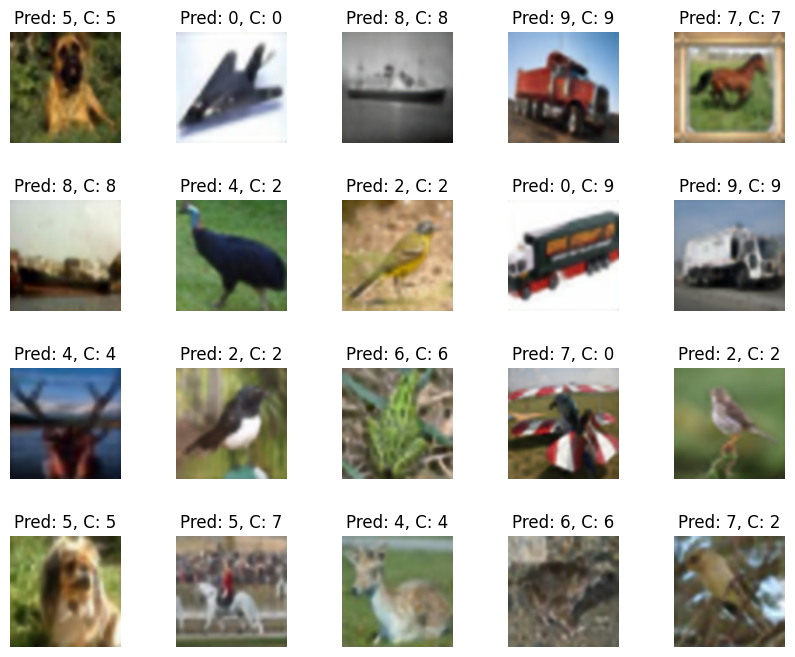

In [ ]:
visualizacionEntrenamiento(model_o, dataloader['test'])

## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.